In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway, f
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Load dataset
file_path = "Bodyfat.txt"
fat = pd.read_csv(file_path, sep=" ", decimal=".")

# Overview of dataset structure
print(fat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   %Fat     252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdom    252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  F-arm    252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB
None


In [3]:
# Model with 3 predictors
X1 = fat[["Weight", "Neck", "Abdom"]]
y = fat["%Fat"]

model1 = LinearRegression()
model1.fit(X1, y)

LinearRegression()

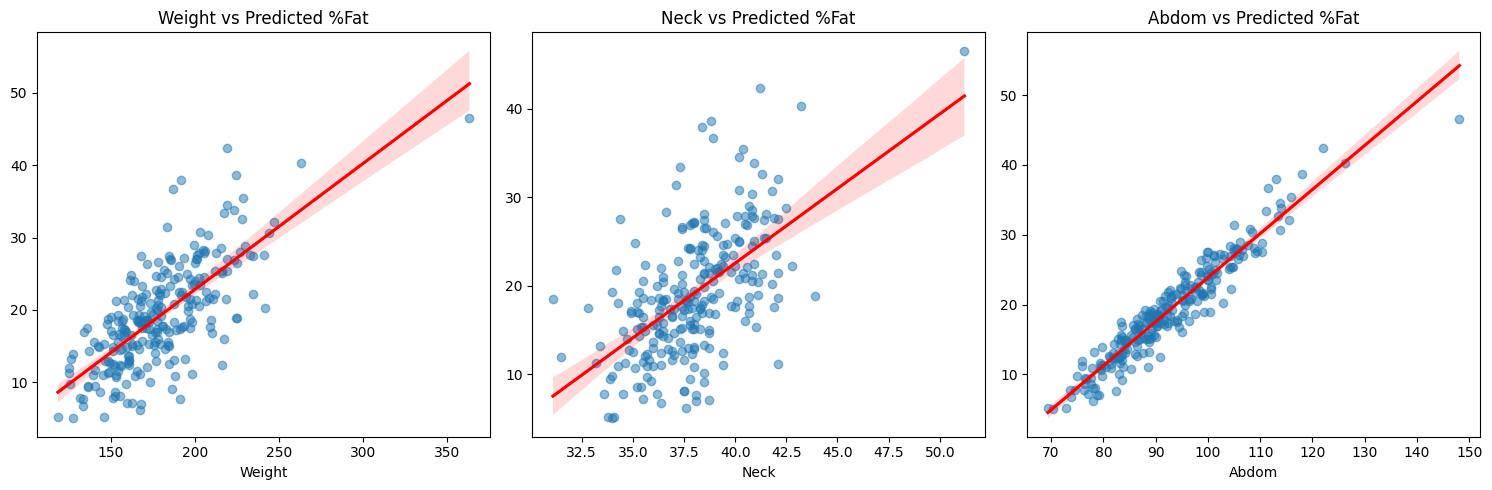

In [13]:
# Visualizing the first linear model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

predictors_model1 = ["Weight", "Neck", "Abdom"]

for i, predictor in enumerate(predictors_model1):
    sns.regplot(x=fat[predictor], y=y_pred1, scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=axes[i])
    axes[i].set_title(f"{predictor} vs Predicted %Fat")

plt.tight_layout()
plt.show()

In [4]:
# Model summary
y_pred1 = model1.predict(X1)
print("Model 1 Coefficients:", model1.coef_)
print("Model 1 Intercept:", model1.intercept_)
print("Model 1 R^2 Score:", r2_score(y, y_pred1))
print("Model 1 MSE:", mean_squared_error(y, y_pred1))

Model 1 Coefficients: [-0.12054377 -0.43576437  0.99712578]
Model 1 Intercept: -35.01532260115448
Model 1 R^2 Score: 0.7237431617861396
Model 1 MSE: 19.271095843423716


In [5]:
# Prediction for a new individual
new_data1 = pd.DataFrame([[157, 37, 88]], columns=["Weight", "Neck", "Abdom"])
predicted_fat1 = model1.predict(new_data1)
print("Predicted Body Fat Percentage (Model 1):", predicted_fat1[0])

Predicted Body Fat Percentage (Model 1): 17.683092394463294


In [6]:
# Model with more predictors
X2 = fat[["Weight", "Neck", "Abdom", "Wrist", "F-arm"]]

model2 = LinearRegression()
model2.fit(X2, y)

LinearRegression()

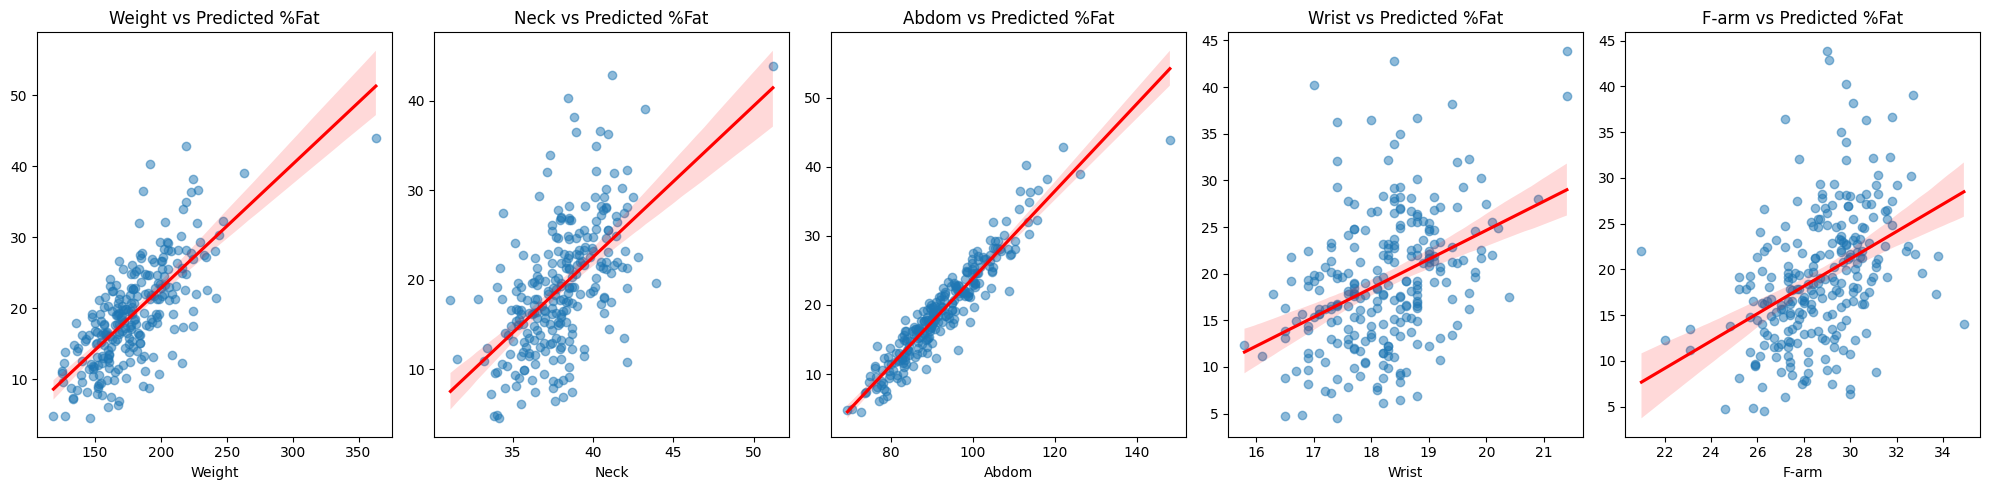

In [14]:
# Visualizing the second linear model
predictors_model2 = ["Weight", "Neck", "Abdom", "Wrist", "F-arm"]

fig, axes = plt.subplots(1, len(predictors_model2), figsize=(20, 5))

for i, predictor in enumerate(predictors_model2):
    sns.regplot(x=fat[predictor], y=y_pred2, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ax=axes[i])
    axes[i].set_title(f"{predictor} vs Predicted %Fat")

plt.tight_layout()
plt.show()

In [7]:
y_pred2 = model2.predict(X2)
print("Model 2 Coefficients:", model2.coef_)
print("Model 2 Intercept:", model2.intercept_)
print("Model 2 R^2 Score:", r2_score(y, y_pred2))
print("Model 2 MSE:", mean_squared_error(y, y_pred2))

Model 2 Coefficients: [-0.12279995 -0.36568417  1.00784461 -1.2462846   0.52703346]
Model 2 Intercept: -30.653577479057475
Model 2 R^2 Score: 0.7379161469620583
Model 2 MSE: 18.282418214741412


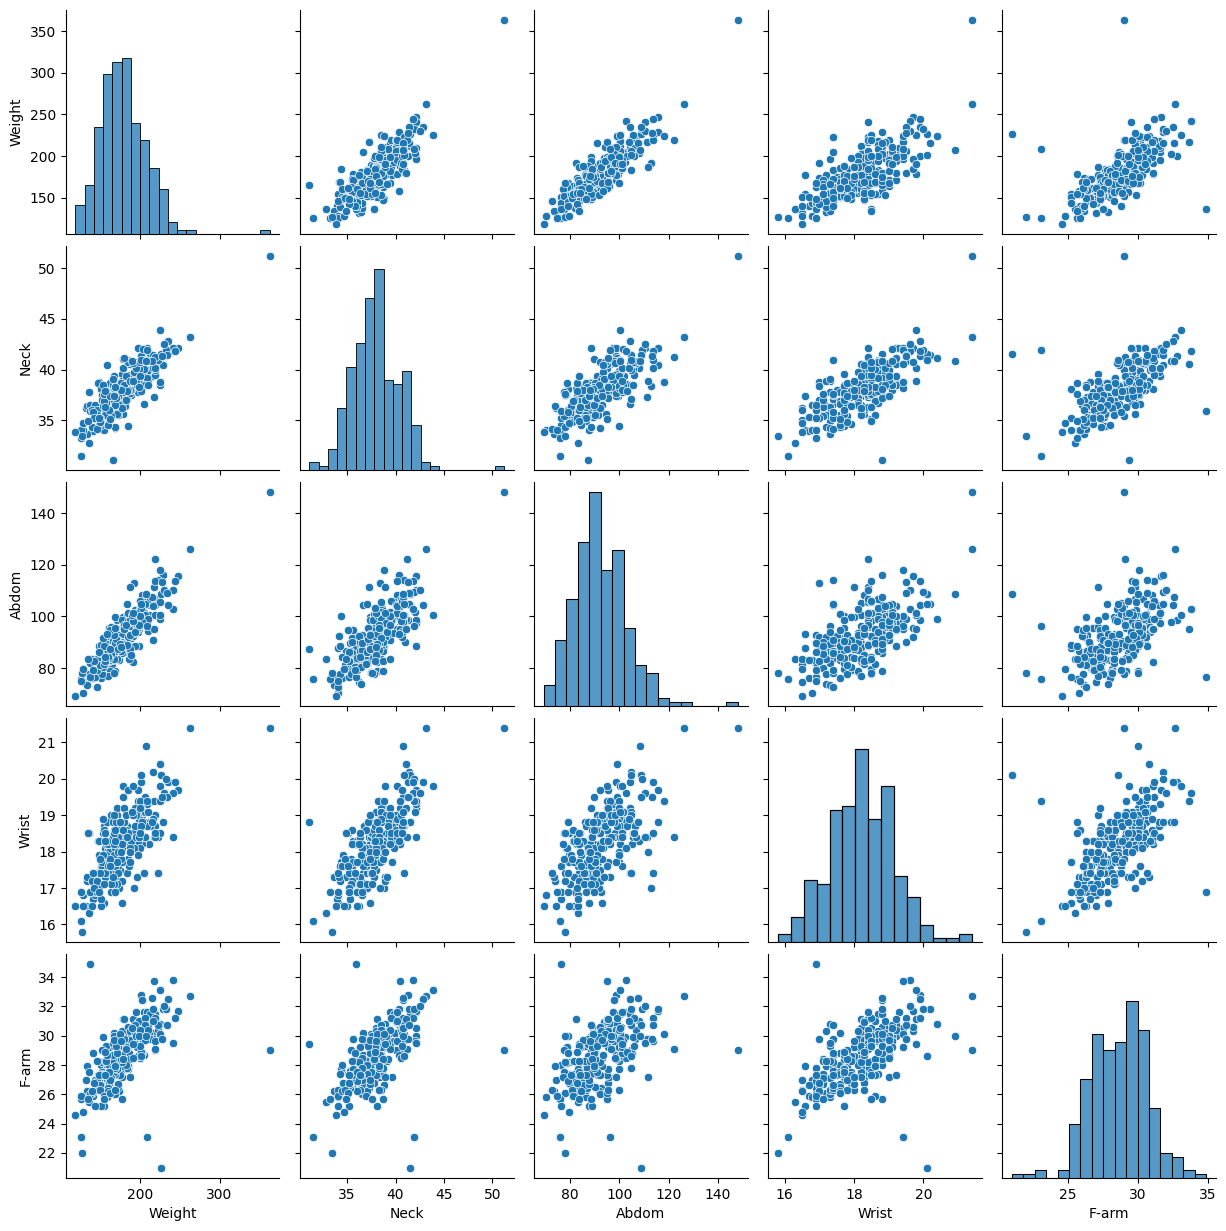

In [8]:
# Visualizing predictor relationships
predictors = ["Weight", "Neck", "Abdom", "Wrist", "F-arm"]
sns.pairplot(fat[predictors])
plt.show()

In [10]:
# Model Comparison (F-test for improvement in larger model)
ssr1 = np.sum((y - y_pred1) ** 2)
ssr2 = np.sum((y - y_pred2) ** 2)

f_stat, p_value = f_oneway(y_pred1, y_pred2)
print("F-statistic:", f_stat)
print("P-value:", p_value)

F-statistic: 2.7010359580030133e-28
P-value: 1.0


In [11]:
"""
f_oneway is designed for ANOVA tests comparing means of multiple independent groups, 
but here, you're comparing residual sums of squares (SSR) from two regression models. 
Instead of f_oneway, we should compute the F-statistic manually for model comparison in regression
"""

"\nf_oneway is designed for ANOVA tests comparing means of multiple independent groups, \nbut here, you're comparing residual sums of squares (SSR) from two regression models. \nInstead of f_oneway, we should compute the F-statistic manually for model comparison in regression\n"

In [12]:
# Model Comparison (F-test for improvement in larger model)
df1 = X2.shape[1] - X1.shape[1]  # Difference in number of predictors
df2 = len(y) - X2.shape[1]  # Residual degrees of freedom for larger model

f_stat = ((ssr1 - ssr2) / df1) / (ssr2 / df2)
p_value = 1 - f.cdf(f_stat, df1, df2)  # Cumulative distribution function for F-test

print("F-statistic:", f_stat)
print("P-value:", p_value)

F-statistic: 6.678639866350518
P-value: 0.001496968472337712


In [18]:
# The function calculating AIC & BIC
def calculate_aic_bic(model, X, y):
    n = len(y)
    k = X.shape[1]  # Includes intercept
    residuals = y - model.predict(X)
    rss = np.sum(residuals**2)
    
    aic = n * np.log(rss / n) + 2 * k
    bic = n * np.log(rss / n) + k * np.log(n)
    
    return aic, bic

In [19]:
# Calculate AIC and BIC
aic1, bic1 = calculate_aic_bic(model1, X1, y)
aic2, bic2 = calculate_aic_bic(model2, X2, y)

print(f"AIC (Model 1): {aic1}, BIC (Model 1): {bic1}")
print(f"AIC (Model 2): {aic2}, BIC (Model 2): {bic2}")

AIC (Model 1): 751.56879986156, BIC (Model 1): 762.1570871240943
AIC (Model 2): 742.2968408732935, BIC (Model 2): 759.9439863108506


In [21]:
# Backward Selection
X_large = fat[["Weight", "Neck", "Abdom", "Chest", "Hip", "Age", "Height", "Wrist", "F-arm"]]
X_large = sm.add_constant(X_large)
model_large = sm.OLS(y, X_large).fit()
print(model_large.summary())

                            OLS Regression Results                            
Dep. Variable:                   %Fat   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     77.61
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           2.97e-66
Time:                        15:09:13   Log-Likelihood:                -721.41
No. Observations:                 252   AIC:                             1463.
Df Residuals:                     242   BIC:                             1498.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0107     16.222     -0.494      0.6

In [22]:
def backward_selection(X, y):
    included = list(X.columns)
    while True:
        model = sm.OLS(y, X[included]).fit()
        p_values = model.pvalues.iloc[1:]  # Exclude intercept
        worst_pval = p_values.max()
        if worst_pval > 0.05:  # Significance level
            worst_feature = p_values.idxmax()
            included.remove(worst_feature)
        else:
            break
    return included, model

selected_features_bw, model_bw = backward_selection(X_large, y)
print("Selected features (backward selection):", selected_features_bw)
print(model_bw.summary())

Selected features (backward selection): ['const', 'Weight', 'Abdom', 'Wrist', 'F-arm']
                            OLS Regression Results                            
Dep. Variable:                   %Fat   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     171.3
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           5.39e-70
Time:                        15:09:23   Log-Likelihood:                -725.11
No. Observations:                 252   AIC:                             1460.
Df Residuals:                     247   BIC:                             1478.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [24]:
# Forward Selection
def forward_selection(X, y):
    included = []
    while True:
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, X[included + [new_column]]).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < 0.05:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
        else:
            break
    return included, model

selected_features_fw, model_fw = forward_selection(X_large, y)
print("Selected features (forward selection):", selected_features_fw)
print(model_fw.summary())

Selected features (forward selection): ['Abdom', 'Wrist', 'Hip', 'Neck', 'F-arm', 'Age']
                                 OLS Regression Results                                
Dep. Variable:                   %Fat   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              797.8
Date:                Thu, 13 Mar 2025   Prob (F-statistic):                   1.12e-164
Time:                        15:37:11   Log-Likelihood:                         -724.15
No. Observations:                 252   AIC:                                      1462.
Df Residuals:                     245   BIC:                                      1487.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std er

In [31]:
# Fit the full model with all predictors
X_all = fat.drop(columns=["%Fat"])  # Remove dependent variable

# Add constant for intercept
X_all = sm.add_constant(X_all)

# Fit the model
model_all = sm.OLS(y, X_all).fit()

# Print summary
print(model_all.summary())

# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_all.drop(columns=["const"]).columns
vif_data["VIF"] = [variance_inflation_factor(X_all.drop(columns=["const"]).values, i) for i in range(X_all.drop(columns=["const"]).shape[1])]

print(vif_data)

                            OLS Regression Results                            
Dep. Variable:                   %Fat   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     756.3
Date:                Thu, 13 Mar 2025   Prob (F-statistic):          8.50e-188
Time:                        16:19:06   Log-Likelihood:                -410.93
No. Observations:                 252   AIC:                             851.9
Df Residuals:                     237   BIC:                             904.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        450.0126     10.713     42.005      0.0

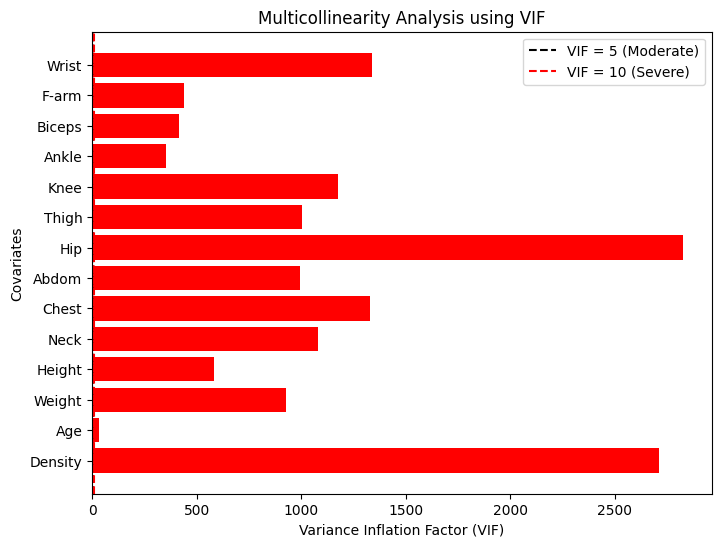

Variables with VIF > 10 (Severe Multicollinearity): ['Density', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdom', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'F-arm', 'Wrist']
Variables with VIF > 5 (Moderate Multicollinearity): []


In [32]:
# Plot VIF values
plt.figure(figsize=(8, 6))
colors = np.where(vif_data["VIF"] > 10, "red", np.where(vif_data["VIF"] > 5, "orange", "blue"))
plt.barh(vif_data["Feature"], vif_data["VIF"], color=colors)
plt.axvline(5, color="black", linestyle="--", label="VIF = 5 (Moderate)")
plt.axvline(10, color="red", linestyle="--", label="VIF = 10 (Severe)")
plt.xlabel("Variance Inflation Factor (VIF)")
plt.ylabel("Covariates")
plt.title("Multicollinearity Analysis using VIF")
plt.legend()
plt.show()

# Show variables with high multicollinearity
print("Variables with VIF > 10 (Severe Multicollinearity):", vif_data[vif_data["VIF"] > 10]["Feature"].tolist())
print("Variables with VIF > 5 (Moderate Multicollinearity):", vif_data[(vif_data["VIF"] > 5) & (vif_data["VIF"] <= 10)]["Feature"].tolist())